In [ ]:
sklearn.datasets.load_diabetes

In [9]:
from sklearn.datasets import load_diabetes

dData, vY = load_diabetes(return_X_y=True, as_frame=True)
display(dData), vY

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


(None,
 0      151.0
 1       75.0
 2      141.0
 3      206.0
 4      135.0
        ...  
 437    178.0
 438    104.0
 439    132.0
 440    220.0
 441     57.0
 Name: target, Length: 442, dtype: float64)

In [20]:
mX  = dData.values
mX -= mX.mean(0)
mX /= mX.std(0)
vY -= vY.mean()
vY /= vY.std()

In [21]:
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics         import r2_score

N     = len(vY)
vHatY = cross_val_predict(LinearRegression(), mX, vY, cv=KFold(N, shuffle=True))
r2_score(vY, vHatY)

0.4937935079824348

In [22]:
mPhi.shape

(442, 285)

In [24]:
from sklearn.preprocessing import PolynomialFeatures

mPhi = PolynomialFeatures(degree=2 ,include_bias=False).fit_transform(mX)

vHatY = cross_val_predict(LinearRegression(), mPhi, vY, cv=KFold(N, shuffle=True))
r2_score(vY, vHatY)

0.4219075542986508

In [38]:
mPhi  = PolynomialFeatures(degree=4 ,include_bias=False).fit_transform(mX)
vHatY = cross_val_predict(Lasso(alpha=0.07), mPhi, vY, cv=KFold(20, shuffle=True))
r2_score(vY, vHatY)

0.4734343000142809

In [110]:
from sklearn.kernel_ridge import KernelRidge

vHatY = cross_val_predict(KernelRidge(kernel='rbf', gamma=0.0015, alpha=0.01), mPhi, vY, cv=KFold(N, shuffle=True))
r2_score(vY, vHatY)

0.5045085291947672

(-1.8572824477429999,
 2.7228996600758055,
 -1.7363584204518532,
 2.1538035529608406)

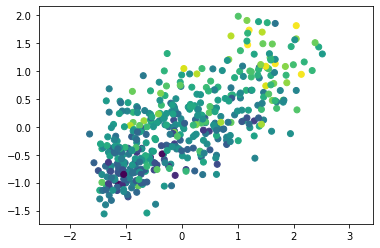

In [124]:
plt.scatter(vY, vHatY, c=mX[:,9])
plt.axis('equal')

In [83]:
from scipy.spatial.distance import cdist
from sklearn.metrics        import r2_score

#-- Gaussian kernel:
def Kernel(vU):
    return np.exp(-vU**2 / (2 * h)**2).squeeze()

#-- Estimate f(x_0):
def LocalPolynomialRegression(vX0, mX, vY, h):
    
    #-- Compute 2nd order polynomial features:
    mPhi   = PolynomialFeatures(degree=3, include_bias=False).fit_transform(mX - vX0)
    
    #-- Compute u = H^-1||x_0 - x_i||
    vU  = cdist(vX0[None,:], mX, metric='mahalanobis') / h
#     vU  = cdist(vX0[None,:], mX) / h
    
    #-- Compute weightes aorund x_0:
    vW  = Kernel(vU)
    
    #-- Train a weighted linear regression: 
    oLR = LinearRegression().fit(mPhi, vY, sample_weight=vW)
    
    
    #-- predict
    d    = mPhi.shape[1]
    yHat = oLR.predict(np.zeros((1, d)))
    return yHat

In [84]:
vY = vY.values
mX.shape, vY.shape

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [90]:
import numpy as np

N      = len(vY)
K      = 15
vHatY  = np.full(N, np.nan)
vScore = np.full(K, np.nan)

#-- test different h values:
vH = np.linspace(1.0, 2.5, K, endpoint=True)
for kk in range(K):
    h = vH[kk]
    print(f'{kk:03d}: h = {h}', end='\r')
    
    for ii in range(N):
        #-- Leave one out cross-validation:
        mXi       = np.delete(mX, ii, 0)
        vYi       = np.delete(vY, ii)
        vXi       = mX[ii,:]
        vHatY[ii] = LocalPolynomialRegression(vXi, mXi, vYi, h)

    vScore[kk] = r2_score(vY, vHatY)
    
vScore

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.stem(vH,         vScore,                   label='Local polynomial regression')
# plt.plot(vH[[0,-1]], [scoreLR, scoreLR], ':r', label='Polynomial regression')
plt.title(f'max $r^2$ score = {vScore.max()}')
plt.xlabel('$h$')
# plt.ylim([0.8, 0.9])
plt.legend()
plt.grid()

In [ ]:
print(load_diabetes()['DESCR'])

In [92]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

vHatY = cross_val_predict(RandomForestRegressor(), mX, vY, cv=KFold(N, shuffle=True))
r2_score(vY, vHatY)

0.4161796605991537

In [104]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

vHatY = cross_val_predict(GradientBoostingRegressor(), mX, vY, cv=KFold(N, shuffle=True))
r2_score(vY, vHatY)

0.42261870130332413

In [105]:
import seaborn as sns

In [108]:
dData2 = dData.copy()
dData2['Target'] = vY > 0
dData2

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Target
0,0.800500,1.065488,1.297088,0.459840,-0.929746,-0.732065,-0.912451,-0.054499,0.418551,-0.370989,False
1,-0.039567,-0.938537,-1.082180,-0.553511,-0.177624,-0.402886,1.564414,-0.830301,-1.436551,-1.938479,False
2,1.793307,1.065488,0.934533,-0.119218,-0.958674,-0.718897,-0.680245,-0.054499,0.060207,-0.545154,False
3,-1.872441,-0.938537,-0.243771,-0.770658,0.256292,0.525397,-0.757647,0.721302,0.477072,-0.196823,True
4,0.113172,-0.938537,-0.764944,0.459840,0.082726,0.327890,0.171178,-0.054499,-0.672582,-0.980568,False
...,...,...,...,...,...,...,...,...,...,...,...
437,0.876870,1.065488,0.413360,1.256044,-0.119769,-0.053957,-0.602843,-0.054499,0.655795,0.151508,True
438,-0.115937,1.065488,-0.334410,-1.422098,1.037341,1.664355,-0.602843,0.721302,-0.380915,0.935254,False
439,0.876870,1.065488,-0.334410,0.363330,-0.785107,-0.290965,-0.525441,-0.232934,-0.985585,0.325674,False
440,-0.956004,-0.938537,0.821235,0.025547,0.343075,0.321306,-0.602843,0.558384,0.936155,-0.545154,True


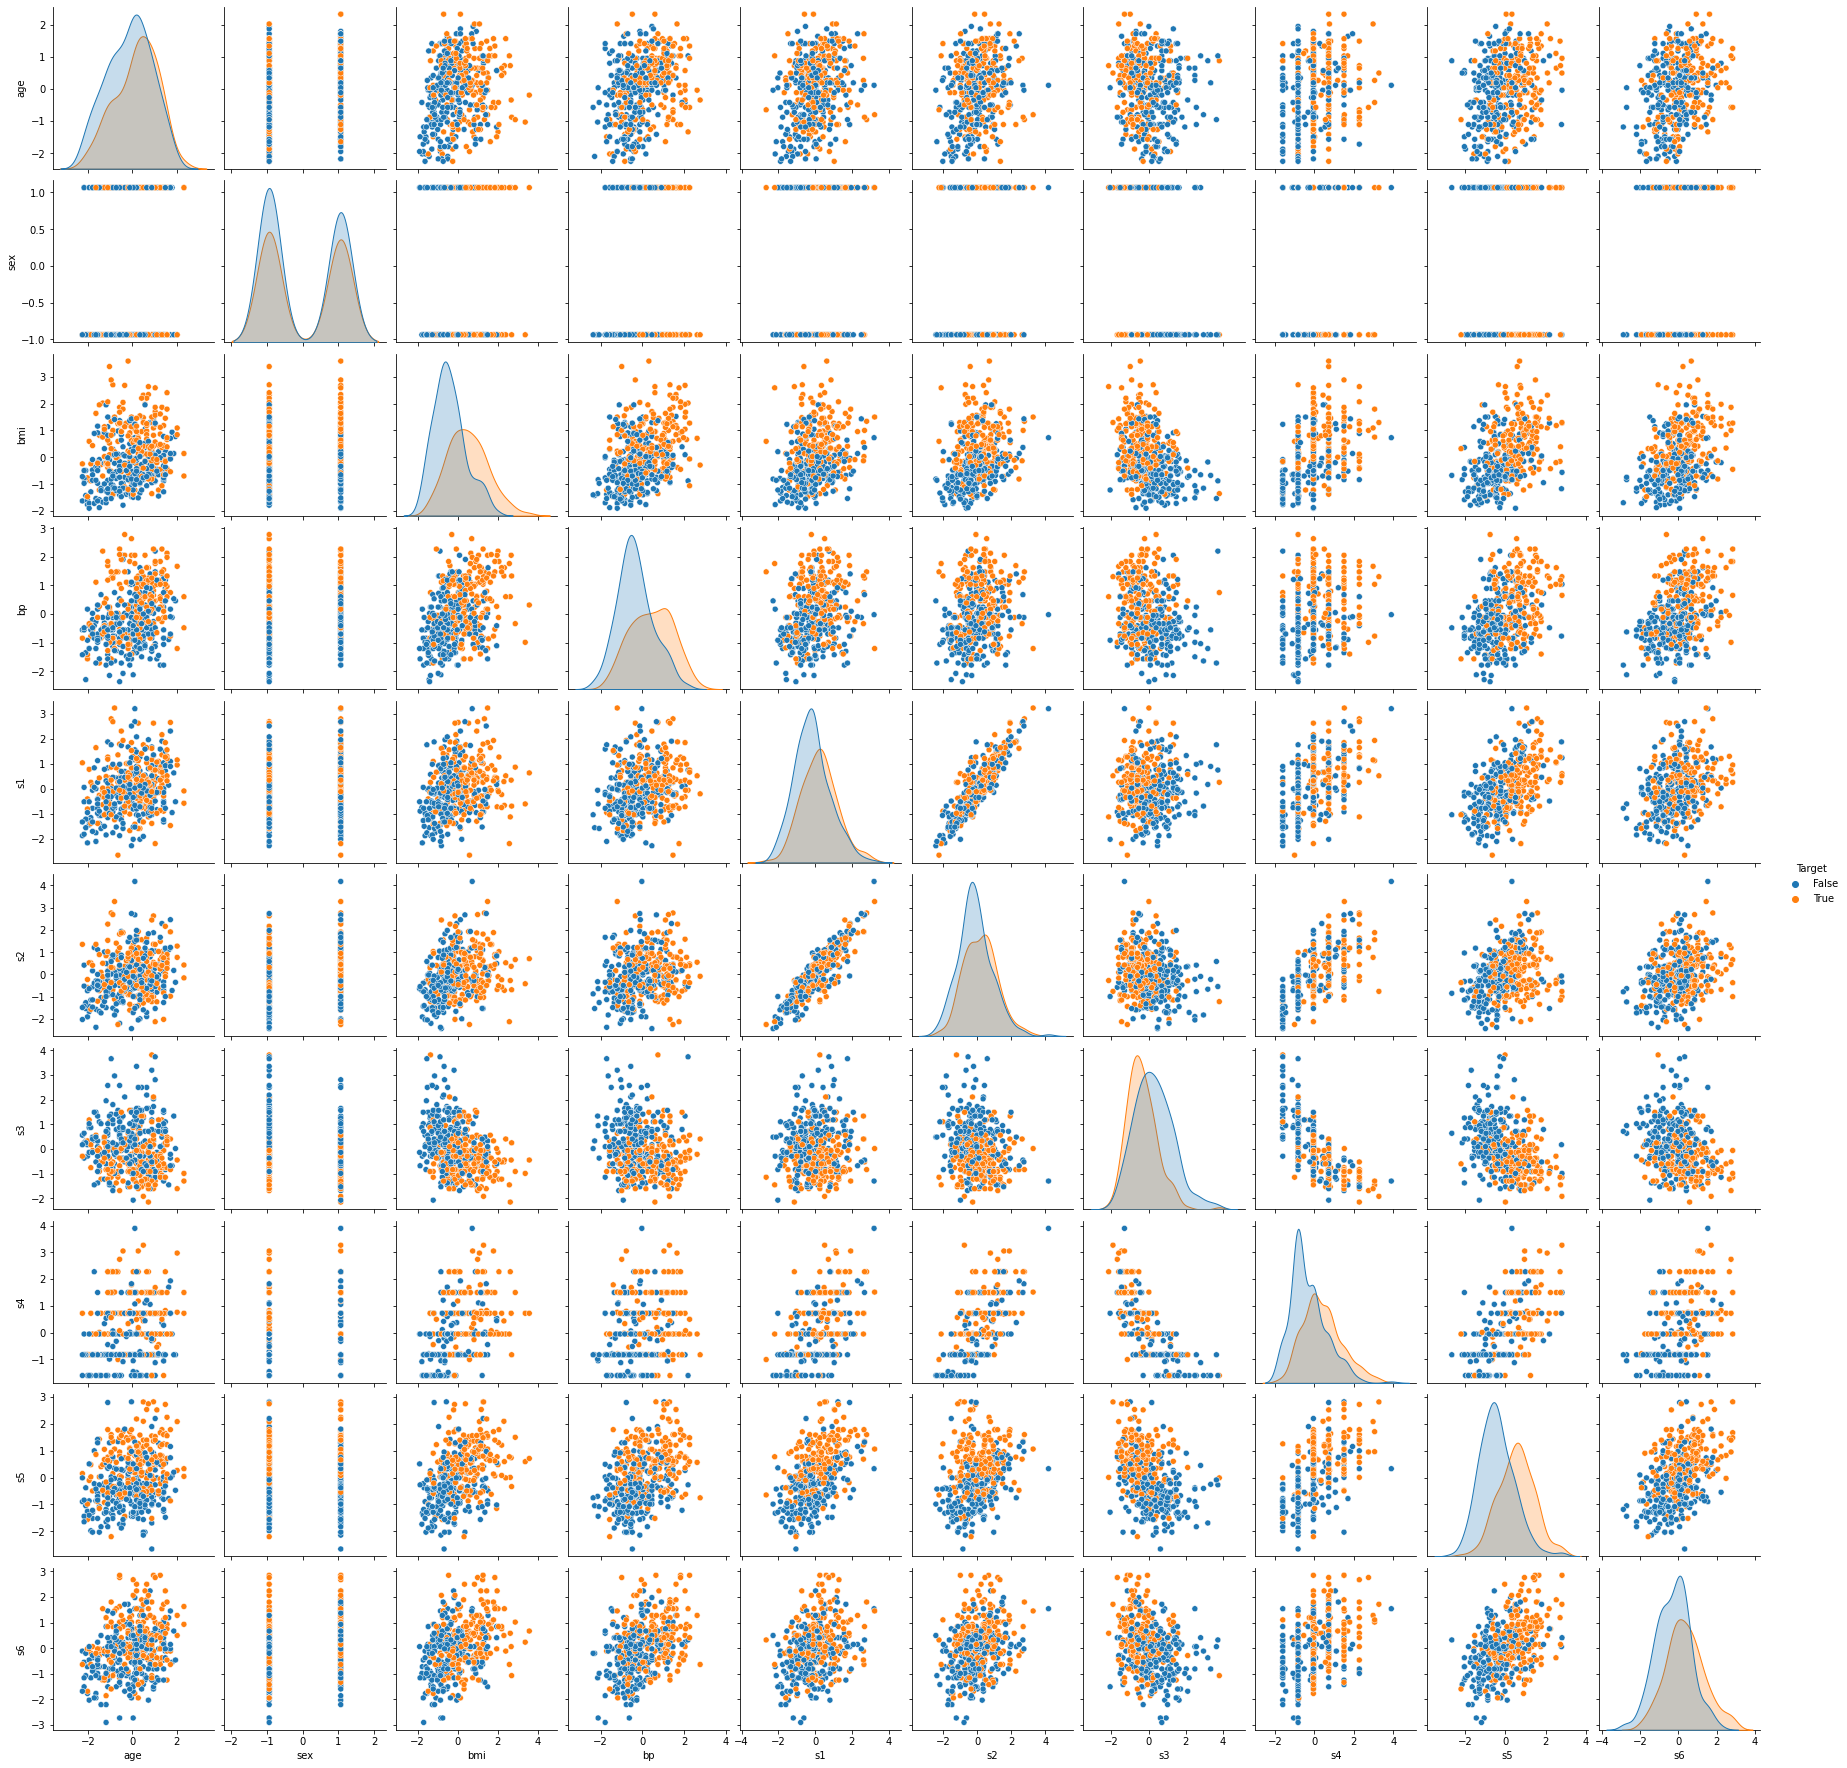

In [109]:
sns.pairplot(dData2, hue='Target')

In [206]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model  import Lasso
from sklearn.pipeline      import Pipeline

N     = 100
d     = 2
mX    = np.random.randn(N, 2)
vY    = np.random.randn(N)
vW    = np.random.rand(N)

oPipe    = Pipeline(steps=[('PolynomialFeatures', PolynomialFeatures(degree=10)), ('Lasso', Lasso())])
dFitArgs = {'Lasso__sample_weight' : vW}

oPipe.fit  (mX, vY, **dFitArgs)
oPipe.score(mX, vY)


0.09719815304140023